### Automated anomaly detection using PyOD and Auto-Sklearn
This notebook incorporates anomaly detection algorithms from PyOD into Auto-Sklearn. The following steps are followed:
- Auto-Sklearn is extended to incorporate PyOD algorithms
- Anomaly detection dataset(s) are imported and pre-processed
- Dataset is passed to Auto-Sklearn automl object for automated modeling and prediction
- Results and stats are obtained and analyzed

In [ ]:
# Imports
import pandas as pd
import numpy as np
import sklearn.metrics
import autosklearn.classification
from sklearn.model_selection import train_test_split
from autosklearn.metrics import roc_auc
from scipy.io import arff
from matplotlib import pyplot as plt

In [8]:
# Shuttle dataset
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
mat = loadmat('datasets/shuttle.mat')  # load mat-file
X = mat['X']
y = mat['y']
X = pd.DataFrame(X)
y = pd.DataFrame(y)
y = y[0]
N = 1000
if(len(X) > N):
    X = X.sample(n=N, ignore_index=True, random_state=1)
    y = y.sample(n=N, ignore_index=True, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y) # stratified split
# Reset indexes
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
#X_train_norm = X_train.copy()
#X_test_norm = X_test.copy()
#for col in X_train_norm.columns:
#    mu = X_train_norm[col].mean()
#    sig = X_train_norm[col].std()
#    X_train_norm[col] = (X_train_norm[col] - mu) / sig
#    X_test_norm[col] = (X_test_norm[col] - mu) / sig
#X_train = X_train_norm.copy()
#X_test = X_test_norm.copy()
print("Ratio of outliers in training set:", len(y_train[y_train==1])/len(y_train))
print("Ratio of outliers in test set:", len(y_test[y_test==1])/len(y_test))
print("Training size:", len(X_train))
print("Test size:", len(X_test))

Ratio of outliers in training set: 0.0675
Ratio of outliers in test set: 0.065
Training size: 800
Test size: 200


In [3]:
# Add PyOD classifiers to the pipeline components of auto-sklearn
from pyod_models.knn import KNNClassifier
from pyod_models.lof import LOFClassifier
from pyod_models.copod import COPODClassifier
from pyod_models.abod import ABODClassifier
from pyod_models.iforest import IForestClassifier
from pyod_models.ecod import ECODClassifier
from pyod_models.mad import MADClassifier
from pyod_models.sos import SOSClassifier
from pyod_models.lmdd import LMDDClassifier
from pyod_models.cblof import CBLOFClassifier
from pyod_models.loci import LOCIClassifier
from pyod_models.hbos import HBOSClassifier
from pyod_models.sod import SODClassifier
from pyod_models.rod import RODClassifier
autosklearn.pipeline.components.classification.add_classifier(KNNClassifier)
autosklearn.pipeline.components.classification.add_classifier(LOFClassifier)
autosklearn.pipeline.components.classification.add_classifier(ABODClassifier)
autosklearn.pipeline.components.classification.add_classifier(COPODClassifier)
autosklearn.pipeline.components.classification.add_classifier(IForestClassifier)
autosklearn.pipeline.components.classification.add_classifier(ECODClassifier)
autosklearn.pipeline.components.classification.add_classifier(MADClassifier)
autosklearn.pipeline.components.classification.add_classifier(SOSClassifier)
autosklearn.pipeline.components.classification.add_classifier(LMDDClassifier)
autosklearn.pipeline.components.classification.add_classifier(CBLOFClassifier)
autosklearn.pipeline.components.classification.add_classifier(LOCIClassifier)
autosklearn.pipeline.components.classification.add_classifier(HBOSClassifier)
autosklearn.pipeline.components.classification.add_classifier(SODClassifier)
autosklearn.pipeline.components.classification.add_classifier(RODClassifier)

In [9]:
# Build and fit a classifier
automl = autosklearn.classification.AutoSklearnClassifier(
    include = {
      'classifier': [
          'HBOSClassifier',
          'RODClassifier',
          'SODClassifier',
      ],
      'feature_preprocessor': ["no_preprocessing"],
    },
    exclude=None,
    metric=autosklearn.metrics.roc_auc,
    time_left_for_this_task=360,
    per_run_time_limit=30,
    ensemble_size=5,
    initial_configurations_via_metalearning=0,
    #resampling_strategy='holdout',
    #resampling_strategy_arguments={'train_size': 0.67}
    resampling_strategy='cv',
    resampling_strategy_arguments={'folds': 10}
)
# Fit
automl.fit(X_train, y_train, X_test, y_test, dataset_name='Shuttle')

AutoSklearnClassifier(ensemble_size=5,
                      include={'classifier': ['HBOSClassifier', 'RODClassifier',
                                              'SODClassifier'],
                               'feature_preprocessor': ['no_preprocessing']},
                      initial_configurations_via_metalearning=0, metric=roc_auc,
                      per_run_time_limit=30, resampling_strategy='cv',
                      resampling_strategy_arguments={'folds': 10},
                      time_left_for_this_task=360)

In [10]:
# auto-sklearn execution details
print(automl.sprint_statistics())
# Top ranked model
#print(automl.leaderboard(top_k=10))
# Top ranked model configuration
#print()
#print(automl.show_models())

auto-sklearn results:
  Dataset name: Shuttle
  Metric: roc_auc
  Best validation score: 0.987220
  Number of target algorithm runs: 16
  Number of successful target algorithm runs: 7
  Number of crashed target algorithm runs: 4
  Number of target algorithms that exceeded the time limit: 5
  Number of target algorithms that exceeded the memory limit: 0



In [11]:
# Evaluate on test set
y_pred=automl.predict_proba(X_test)
# score
score=sklearn.metrics.roc_auc_score(y_test,y_pred[:,1])
print("ROC AUC score:", score)

ROC AUC score: 0.9979432332373509


In [12]:
# Get metric results function definition
def get_metric_result(cv_results):
    results = pd.DataFrame.from_dict(cv_results)
    #results = results[results['status'] == "Success"] # if we're interested only in successful runs
    cols = ['rank_test_scores', 'status', 'param_classifier:__choice__', 'mean_test_score', 'mean_fit_time']
    cols.extend([key for key in cv_results.keys() if key.startswith('metric_')]) # if there are additional metrics
    return results[cols].sort_values(['rank_test_scores'])
# Call the function
print(get_metric_result(automl.cv_results_).to_string(index=False))

 rank_test_scores  status param_classifier:__choice__  mean_test_score  mean_fit_time
                1 Success              HBOSClassifier         0.987220      10.024480
                2 Success              HBOSClassifier         0.980153      16.332729
                3 Success              HBOSClassifier         0.975868      10.731966
                4 Success              HBOSClassifier         0.974085      19.547463
                5 Success              HBOSClassifier         0.970274      20.781672
                6 Success              HBOSClassifier         0.955901      21.764272
                7 Success              HBOSClassifier         0.933400      21.310738
                8 Timeout               RODClassifier         0.000000      30.041747
                8   Crash               SODClassifier         0.000000      11.554686
                8 Timeout               RODClassifier         0.000000      30.044482
                8   Crash               SODClassifier 

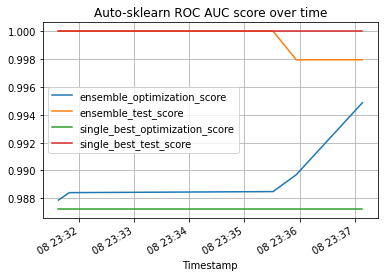

In [13]:
# Plot training performance over time
automl.performance_over_time_.plot(
   x='Timestamp',
   kind='line',
   legend=True,
   title='Auto-sklearn ROC AUC score over time',
   grid=True,
)
plt.show()